# Vignette: Integrative modelling of pathogen spread through animal trade by accounting for farmers’ control decisions 

In [105]:
# Import modules

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from datetime import datetime
import Epi_decision_functions as epidec # Import our module

## Fixed simulation setting

Setting can be eventually be modified in the fixes_parameters folder according to the study. Evidently, more herds in the meta-population, more years to simulate, or more runs will take longer to simulate.

In [106]:
#Read fixed simulation setting, fixed demographic parameters, and fixed network structure:

N0s = np.loadtxt('/home/lcristancho/Documents/simulations_cluster/SA_12nov_epi/fixed_parameters/N0s.txt')
L = len(N0s)
delta, nb_steps = np.loadtxt('/home/lcristancho/Documents/simulations_cluster/SA_12nov_epi/fixed_parameters/setting.txt')
nb_steps = int(nb_steps)
demo_params = np.loadtxt('/home/lcristancho/Documents/simulations_cluster/SA_12nov_epi/fixed_parameters/demo_params.txt')
theta_edges = np.loadtxt('/home/lcristancho/Documents/simulations_cluster/SA_12nov_epi/fixed_parameters/theta_edges.txt')

print('Number of herds:', L)
print('Simulation step delta:', delta)
print('Simulated years:', int(nb_steps*delta/365))
print('Demographic parameters (mu and tau):', demo_params[0])

Number of herds: 5000
Simulation step delta: 0.5
Simulated years: 3
Demographic parameters (mu and tau): [0.00182648 0.00091324]


# Fix model parameters

To modify according to the study

In [107]:
# Epidemic parameters
prop_inf_nodes = 0.1 # proportion of initially infected nodes 
prop_inf_in_node = 0.15 # proportion of animals infected in the infected nodes 
recovery_time = 90 #1/gamma
beta_gamma = 2 #beta/gamma

# Economic parameters
r = 2000
phi = 0.8
cf_vacc = 50
cu_vacc = 5

# Decision parameters
eff_protect = 1 #efficacy of the vaccine
duration_decision = 180 
init_proba_vacc = 0.01
kappa = 1.
rapport_rho_kappa = 0.5

print('Prop. of initially infected nodes: ', prop_inf_nodes)
print('Prop. infected animals in the initially infected nodes: ', prop_inf_in_node)
print('Infetious period (1/gamma): ', recovery_time)
print('Beta/Gamma: ', beta_gamma)
print('Value of a healthy animal (r): ', r)
print('Loss of value of an infected animal (phi): ', phi)
print('Protection efficacy of the vaccin: ', eff_protect)
print('Fixed cost of vaccine: ', cf_vacc)
print('Unit cost of vaccine: ', cu_vacc)
print('Duration of vaccine protection (and of decision): ', duration_decision)
print('Initial probability of vaccinating:', init_proba_vacc)
print('kappa (Farmer\'s sensitivity to own results): ', kappa)
print('kappa / rho (Farmer\'s sensitivity to neighbor\'s results): ', rapport_rho_kappa)


Prop. of initially infected nodes:  0.1
Prop. infected animals in the initially infected nodes:  0.15
Infetious period (1/gamma):  90
Beta/Gamma:  2
Value of a healthy animal (r):  2000
Loss of value of an infected animal (phi):  0.8
Protection efficacy of the vaccin:  1
Fixed cost of vaccine:  50
Unit cost of vaccine:  5
Duration of vaccine protection (and of decision):  180
Initial probability of vaccinating: 0.01
kappa (Farmer's sensitivity to own results):  1.0
kappa / rho (Farmer's sensitivity to neighbor's results):  0.5


### Fixed useful arrays for the epidemic-decision path
Do not modify

In [92]:
# Useful fixed parameters
gamma = 1/recovery_time
beta = beta_gamma*gamma
rho = rapport_rho_kappa*kappa
eff_reduceinfec = 0
epid_params = np.array([[beta, gamma]]*L)
eco_params = np.array([r, phi, cu_vacc, cf_vacc])
nexpw_params = np.array([init_proba_vacc, kappa, rho])

#Fixed useful arrays for the epidemic-decision path

#thetas et probas de sortie (fct de matrix theta_edges)
probs_edges = epidec.proba_edges(L, theta_edges, delta) # k, sum_theta_k, p_out_k (vector)

#thetas
mus, taus = demo_params[:,0], demo_params[:,1]
thetas = probs_edges[:,1].astype(float)

#list of prob. of exit
probs_exports = list(probs_edges[:,2])

# list of childs of each herd (for imports later)
neighbors_list = theta_edges[:,1].astype(int)

# list of parents of each herd (for returns later)
parents_list = theta_edges[:, 0].astype(int)

#theta edges in format for neighbor ewpw strategy

theta_edges_compact = []
for k in range(0,L):
    neighbors_k = []
    for w in theta_edges[theta_edges[:,0]== k]:
        neighbors_k.append(int(w[1]))
    for w in theta_edges[theta_edges[:,1]== k]:
        neighbors_k.append(int(w[0]))
    theta_edges_compact.append([k, neighbors_k ])
theta_edges_compact = np.array(theta_edges_compact, dtype=object)


#Fixed probabilities

# prob. of birth
p_B = 1.0 - np.exp(-mus * delta)

#prob. for R 
R_rates = taus + thetas
p_RD=  (1.0 - np.exp(- R_rates * delta))*taus/ R_rates 
p_Rout =  (1.0 - np.exp(-R_rates * delta))*thetas/R_rates 

#prob. for I
I_rates = gamma + R_rates
p_IR =  (1.0 - np.exp(-I_rates * delta))*gamma/I_rates
p_ID =  (1.0 - np.exp(-I_rates * delta))*taus/I_rates
p_Iout = (1.0 - np.exp(-I_rates * delta))*thetas/I_rates

#Stock prob. vectors
p_B = np.array([p_B, 1.0-p_B]).T 
p_I = np.array([p_IR, p_ID, p_Iout, 1.0-(p_IR + p_ID + p_Iout)]).T 
p_R = np.array([p_RD, p_Rout, 1.0-(p_RD + p_Rout)]).T

#fixed_epid_probas 
fixed_epid_probas = [p_B, p_I, p_R]

## Choose the number of runs to simulate
Attention, this code is not parallelized. A single run takes approximately 1min50.

In [108]:
simulations = 5

## Create random initial epidemic states with the given parameters, for each run

In [ ]:
# Initial epidemic state creation 
    
all_initial_states = []

for i in range(0, simulations):
    
    random.seed(i)

    perm = random.sample(range(L), L)
    num_infected_noeuds = int(prop_inf_nodes*L)

    initial_states_inf = []
    initial_states_noninf = [] 
    for k in perm[:num_infected_noeuds]:
        initial_states_inf.append([k, epidec.create_initial_state(k, N0s, prop_inf_in_node)])
    for k in perm[num_infected_noeuds:]:
        initial_states_noninf.append([k, epidec.create_initial_state(k, N0s, 0)])
    initial_states = initial_states_inf + initial_states_noninf
    initial_states = sorted(initial_states, key=lambda index: index[0])
    initial_states = np.stack(np.array(initial_states, dtype=object)[:, 1])
    all_initial_states.append(initial_states)
    
    all_initial_states.append(initial_states)

## Run simulations
Only eventually modify the decision mechanism to 'nothing' (no farmer ever vaccinates) or 'always' (all farmers vaccinate)

In [93]:
chosen_mechanism = 'neighb_expw'

In [94]:
action_results = np.zeros((simulations, nb_steps, L, 8))
action_behaviors = np.zeros((simulations, nb_steps, L))
start_time = datetime.now()
for i in range(0, simulations):    
    decision_times_i, behavior_i, results_i, ventes_i, achats_i = epidec.path(all_initial_states[i],
                                                                              demo_params, epid_params,
                                                                              eco_params,
                                                                              fixed_epid_probas,
                                                                              neighbors_list,
                                                                              parents_list,
                                                                              probs_exports,
                                                                              duration_decision,
                                                                              eff_reduceinfec,
                                                                              eff_protect,
                                                                              thetas, delta,
                                                                              nb_steps, nexpw_params,
                                                                              theta_edges_compact,
                                                                              mechanism = chosen_mechanism)
    action_results[i] = results_i # for each run, we save the full epidemic path by herd
    action_behaviors[i] = behavior_i # for each run, we save the decision path by herd 
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

# Agrregated epidemic path
sir_r = np.zeros((simulations, nb_steps, L, 3))
sir_r[:,:,:,0] = action_results[:,:,:,0] +  action_results[:,:,:,3] #SNV + SV = S
sir_r[:, :,:,1] = action_results[:, :,:,2] + action_results[:, :,:,5]  #INV + IV = I
sir_r[:, :,:,2] = action_results[:, :,:,7]  # R

Duration: 0:10:05.090103


## 4. Some plots on population structure

<Figure size 640x480 with 0 Axes>

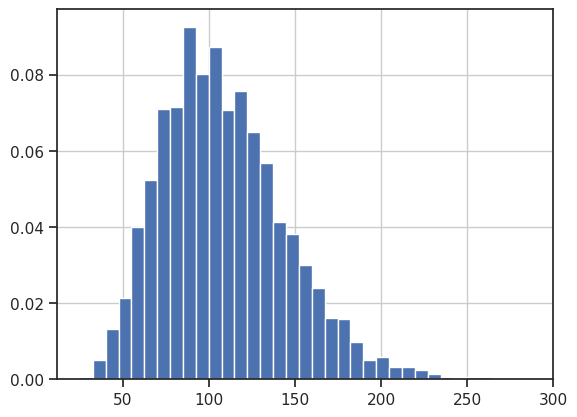

Range initial size: ( 25.0 , 287.0 )


In [109]:
# Plot initial herd size
N0s_pd = pd.DataFrame(N0s)
plt.figure()
N0s_pd.hist(bins =35,  weights=np.zeros_like(N0s_pd) + 1. / N0s_pd.size)
plt.title('')
plt.show()
print('Range initial size:', '(', min(N0s), ',', max(N0s), ')')

<Figure size 640x480 with 0 Axes>

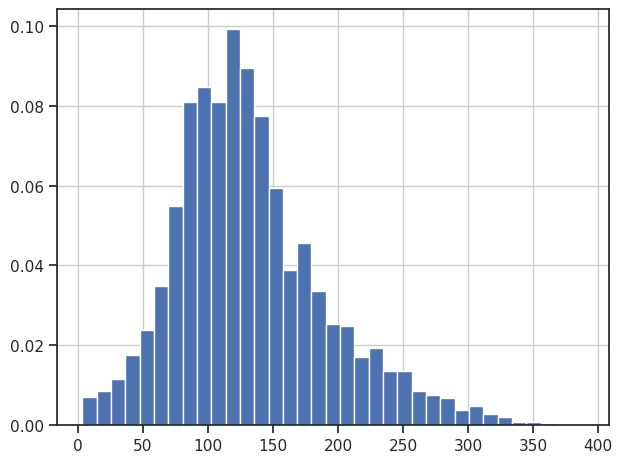

Range final size: ( 3.4 , 388.6 )


In [110]:

# Plot Final mean herd size distribution
N = np.sum(sir_r, axis = 3)
mean_sizes_nopd = np.mean(N, axis = 0)
mean_sizes = pd.DataFrame(mean_sizes_nopd)

N_T = mean_sizes_nopd[nb_steps-1]
N_T_pd = pd.DataFrame(N_T)
plt.figure()
N_T_pd.hist(bins =35,  weights=np.zeros_like(N_T_pd) + 1. / N_T_pd.size)
plt.title('')
plt.tight_layout()
plt.show()

print('Range final size:', '(', min(N_T), ',', max(N_T), ')')


## 5. Some plots on epidemic and decision dynamics

In [97]:
#Proportion of infected herds
N_action = np.sum(sir_r, axis = 3)
I_action = action_results[:,:,:,2]
prop_infected_farms_time_action  = np.sum(I_action!=0, axis = 2)/L
mean_prop_infected_farms_time_action = pd.DataFrame(np.mean(prop_infected_farms_time_action, axis = 0))
upp_prop_infected_farms_time_action = pd.DataFrame(np.percentile(prop_infected_farms_time_action, 90, axis = 0))
low_prop_infected_farms_time_action =  pd.DataFrame(np.percentile(prop_infected_farms_time_action, 10, axis = 0))

#Proportion of herds that vaccinate
prop_vaccinators = np.mean(action_behaviors,axis = 2)[:, decision_times_i]
mean_prop_vaccinators = np.mean(prop_vaccinators, axis = 0)
pd_mean_prop_vaccinators = pd.DataFrame(mean_prop_vaccinators, decision_times_i) 
low_prop_vaccinators = mean_prop_vaccinators -np.percentile(prop_vaccinators, 10, axis = 0) 
upp_prop_vaccinators = np.percentile(prop_vaccinators, 90, axis = 0) - mean_prop_vaccinators
a = np.array([low_prop_vaccinators, upp_prop_vaccinators])


# Proportion of infected animals among infected herds
Iaction_nonzeros = np.zeros((simulations, nb_steps, 3))
for s in range(simulations):
    for t in range(0,nb_steps):
        I_t = np.divide(I_action[s, t], N_action[s,t], out=np.zeros_like(I_action[s, t]), where=N_action[s,t]!=0)
        if I_t[I_t!= 0.0].size:
            Iaction_nonzeros[s, t, 0] = np.nanmean(I_t[I_t!= 0.0]) 
            Iaction_nonzeros[s, t, 1] = np.nanpercentile(I_t[I_t!= 0.0], 90)
            Iaction_nonzeros[s, t, 2] = np.nanpercentile(I_t[I_t!= 0.0], 10)
        else:
            Iaction_nonzeros[s, t, 0] = 0
            Iaction_nonzeros[s, t, 1] = 0
            Iaction_nonzeros[s, t, 2] = 0
Iaction_pd_nonzeros = pd.DataFrame(Iaction_nonzeros[:, :, 0].T)
UC_Iaction_pd_nonzeros = pd.DataFrame(Iaction_nonzeros[:, :, 1].T)
LC_Iaction_pd_nonzeros = pd.DataFrame(Iaction_nonzeros[:, :, 2].T)
prop_intra_action_mean = pd.DataFrame(np.mean(Iaction_pd_nonzeros, axis = 1))
prop_intra_action_upp = pd.DataFrame(np.percentile(UC_Iaction_pd_nonzeros, axis = 1, q = 90))
prop_intra_action_low = pd.DataFrame(np.percentile(LC_Iaction_pd_nonzeros, axis = 1, q =10))

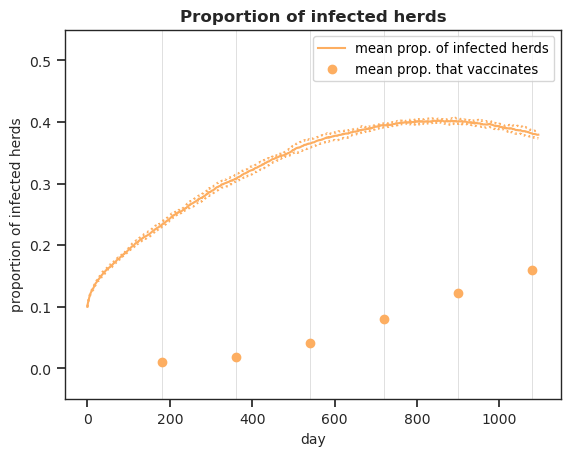

In [111]:
plt.rcParams.update({'font.size': 10})
f, ax = plt.subplots(1)
for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(1)
plt.style.use("default")
plt.ylim([-0.05,0.55])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

xpoints = (decision_times_i*delta).astype(int)

for p in xpoints:
    plt.axvline(p, 0, 1, label='pyplot vertical line', linewidth = 0.5, color = 'lightgray')

days = []
for i in range(nb_steps):
    days.append(i*0.5)

action_line = plt.plot(days, mean_prop_infected_farms_time_action[0], linewidth = 1.5, color= '#fdae61')
upp_action_line = plt.plot(days, upp_prop_infected_farms_time_action[0] ,  linestyle=':',  linewidth = 1.5,color= '#fdae61' )
low_action_line = plt.plot(days, low_prop_infected_farms_time_action[0] ,  linestyle=':', linewidth =1.5,color= '#fdae61' )

plt.title('Proportion of infected herds', fontweight = "bold")
plt.xlabel("day", fontsize = 10)
plt.ylabel("proportion of infected herds", fontsize = 10)
plt.errorbar(xpoints, np.array(pd_mean_prop_vaccinators), yerr=a, fmt = 'o', color = '#fdae61',linewidth = 1.5)


action = mlines.Line2D([], [], color='#fdae61', linewidth=1.5, label='mean prop. of infected herds')
points =  mlines.Line2D(range(1), range(1), linewidth=0, color='#fdae61', marker = 'o', label= 'mean prop. that vaccinates')

legend = plt.legend(handles = [action, points], prop=fontP)
frame = legend.get_frame()

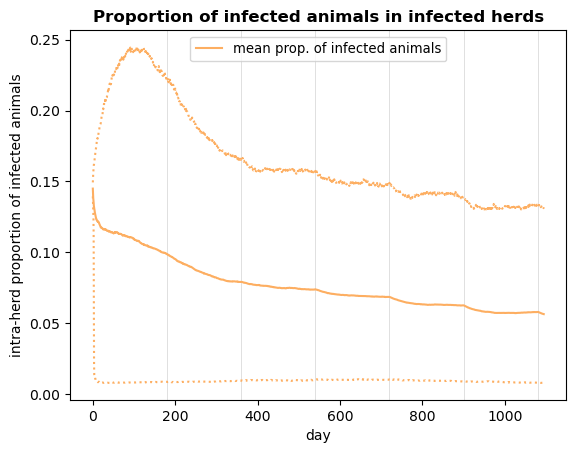

In [112]:
for p in xpoints:
    plt.axvline(p, 0, 1, label='pyplot vertical line', linewidth = 0.5, color = 'lightgray')

upp_action_line = plt.plot(days, prop_intra_action_upp[0], linewidth = 1.5, color = '#fdae61', label = 'Q90',linestyle=':')
low_action_line = plt.plot(days, prop_intra_action_low[0], linewidth = 1.5, color = '#fdae61', label = 'Q10', linestyle=':')
mean_action_line = plt.plot(days, prop_intra_action_mean[0], linewidth = 1.5, color = '#fdae61', label = 'action')

plt.title('Proportion of infected animals in infected herds', fontweight = "bold")
plt.xlabel("day", fontsize = 10)
plt.ylabel("intra-herd proportion of infected animals", fontsize = 10)
frame.set_facecolor("white")
frame.set_linewidth(0)

action = mlines.Line2D([], [], color='#fdae61', linewidth=1.5, label='mean prop. of infected animals')
legend = plt.legend(handles = [action], prop=fontP)
frame = legend.get_frame()